In [47]:
#import packages
import numpy as np
from random import random, seed
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sklearn.linear_model as skl

In [48]:
#define Franke function uglified
def FrankeFunction(x,y): #still got one division in here
    term1 = 0.75*np.exp(-(0.25*(9*x-2)*(9*x-2)) - 0.25*((9*y-2)*(9*y-2)))
    term2 = 0.75*np.exp(-((9*x+1)*(9*x+1))/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)*(9*x-7)*0.25 - 0.25*((9*y-3)*(9*y-3)))
    term4 = -0.2*np.exp(-(9*x-4)*(9*x-4) - (9*y-7)*(9*y-7))
    return term1 + term2 + term3 + term4

In [49]:
# create model matrix
# Form is: x0y0, x1y0, x2y0, x0y1, x1y1, x0y2
def Model(x,y,P): # P is polynomial degree
    m = len(x)*len(y) # number of equations
    t = sum(range(P+2)) # number of terms in polynomial
    X = np.zeros((m,t)) # Model matrix
    a = np.matrix.flatten(x)
    b = np.matrix.flatten(y)
    c = 0 #counter
    for i in range(P+1):
        for j in range(P+1-i):
            X[:,c] = a**j*b**i
            c +=1
    return X

In [50]:
#define R2 function
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

In [51]:
#define MSE function
def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

In [52]:
#define variance function
def Var(y_data, y_model,P,X):
    N = len(y_data)
    covar = np.linalg.inv(X.T.dot(X))#sigma2, should be 1 in this case
    vari = np.diagonal(covar)
    return vari

In [53]:
def Bias(y_data, y_model, P, X):
    N = len(y_data) #should probably insert z here
    # also want the expectation values
    #this is where i want to shuffle my data and do 10 kfolds.
    #maybe...
    #can not use each fold and create a mean from them?
    return np.sum((y_data-y_model)*(y_data-y_model))/N

In [54]:
#Create random variables/predictors
np.random.seed(1234)
N = 200 #number of points along x and y axes

# sort this for meshgrid
x = np.random.uniform(0,1,N)
y = np.random.uniform(0,1,N)

x = sorted(x)
y = sorted(y)
x, y = np.meshgrid(x,y,sparse=False)

#create datapoints/results
z = FrankeFunction(x, y)

# Create noise
Noise = 0.1*np.random.randn(N,N)

#add noise
z_n = z+Noise

#flatten for use in functions
z_n = np.matrix.flatten(z_n)
z = np.matrix.flatten(z)

#added a 0 Ridge parameter
_lambda = 0.0

In [55]:
MPD =5 #maximal polynomial degree

X = Model(x,y,MPD) #create model matrix

In [56]:
def NoResampling(X,z_n,_lambda):
    beta = np.linalg.inv(X.T.dot(X)-_lambda*np.eye(len(X[0][:]))).dot(X.T).dot(z_n)

    ztilde = X @ beta

    return MSE(z_n,ztilde), R2(z_n,ztilde)

In [57]:
NoResampling(X,z_n,0)

(0.011750380454071879, 0.8575813086894186)

In [58]:
## find parameters
beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(z_n)

## make prediction
ztilde = X @ beta

In [59]:
######  Makes model matrix, looks different than mine #####
# form: x0y0, x1y0, x0y1, x2y0, x1y1, x0y2
# poly2 = PolynomialFeatures(degree=MPD)
# a = x[:,np.newaxis]
# b = y[:,np.newaxis]
# cc = np.c_[a,b]
# Xskl = poly2.fit_transform(cc) 
##########################################################
# THIS CELL IS CURRENTLY NOT IN USE #

In [60]:
# find parameters
clf = skl.LinearRegression(fit_intercept=False) #False to not center data, i.e. intercept is not 0
clf.fit(X,z_n) 

#make prediction
zpredict = clf.predict(X)

In [61]:
# The mean squared error              
print("Mean squared error (self): %.5f" % MSE(z_n, ztilde))
print("Mean squared error (skl): %.5f" % mean_squared_error(z_n, zpredict))

# Explained variance score: 1 is perfect prediction     
print('R2 score (self): %.5f' %R2(z_n, ztilde))
print('R2 score (skl): %.5f' % r2_score(z_n, zpredict))

Mean squared error (self): 0.01175
Mean squared error (skl): 0.01175
R2 score (self): 0.85758
R2 score (skl): 0.85758


In [62]:
print(Var(z_n, ztilde, MPD,X)) #my variances in betas
print(Var(z_n,zpredict,MPD,X)) #skl variances in betas

[7.55227583e-03 9.61238982e-01 2.15525118e+01 1.05272993e+02
 1.12662593e+02 1.71913430e+01 9.57850488e-01 1.25105603e+01
 5.57881794e+01 6.46391594e+01 1.28782868e+01 2.19658399e+01
 5.62624923e+01 5.42690697e+01 1.13243930e+01 1.06146184e+02
 6.43402927e+01 1.19071661e+01 1.10817552e+02 1.26556959e+01
 1.64554588e+01]
[7.55227583e-03 9.61238982e-01 2.15525118e+01 1.05272993e+02
 1.12662593e+02 1.71913430e+01 9.57850488e-01 1.25105603e+01
 5.57881794e+01 6.46391594e+01 1.28782868e+01 2.19658399e+01
 5.62624923e+01 5.42690697e+01 1.13243930e+01 1.06146184e+02
 6.43402927e+01 1.19071661e+01 1.10817552e+02 1.26556959e+01
 1.64554588e+01]


In [63]:
print(beta) #my betas
print(clf.coef_) #skl betas

[  0.41702431   7.48077741 -32.74719191  45.71933079 -21.87936753
   1.0522422    3.67335504 -14.84407907  44.19121002 -52.88759038
  18.88929074  -8.42832616  20.25089199  -8.63955314  10.60536587
  -7.87735653 -28.232291    -4.66422606  28.14424892  15.58223584
 -15.73512872]
[  0.41702431   7.48077741 -32.7471919   45.71933077 -21.87936751
   1.0522422    3.67335504 -14.84407907  44.19121001 -52.88759036
  18.88929073  -8.42832616  20.25089199  -8.63955315  10.60536587
  -7.87735652 -28.232291    -4.66422606  28.14424892  15.58223584
 -15.73512872]


In [64]:
std = 1.96*np.sqrt(Var(z_n, ztilde, MPD,X))
# print(std)
for i in range(len(std)):
    print(beta[i],std[i])
#these things are huge, something is probably off

0.41702431153354175 0.17033150862931976
7.480777411044229 1.921638798849138
-32.74719191245646 9.099237840102688
45.71933079261066 20.110115083667562
-21.87936752920072 20.803956750874463
1.0522422004568421 8.126639119549067
3.673355041648879 1.9182487939643467
-14.844079068094606 6.932572994792829
44.19121001532446 14.639531069171102
-52.88759037657661 15.758102510654302
18.889290740623757 7.033720665973215
-8.428326161943072 9.186074825137164
20.250891987433544 14.701632240609396
-8.639553143567005 14.438838531884494
10.605365871897092 6.595740149144369
-7.877356526861394 20.193344942064147
-28.232290996767812 15.721630593980052
-4.6642260591257365 6.763325304960402
28.14424891862705 20.632903498405213
15.582235841903179 6.972669604876835
-15.735128720944084 7.950804387314665


In [65]:
# 95% CI: mu +-1.96*sigma

# b

In [66]:
k = 10 # number of folds
partition = 0.2 # percentage of data to use for testing

In [67]:
def kFold(k,X,z_n):
    #shuffle data before doing the kFold
    n = len(X[0,:])
    combi = np.c_[X,z_n]
    np.random.shuffle(combi)
    X, z_n = combi[:,:n], combi[:,n]

    partition = 0.2 # percentage of data to use for testing
    sMSE = 0. #sum mean squared error
    sR2 = 0. #sum R2 score
    
    for i in range(k):
        # Split data
        X_train,X_test,z_train,z_test = train_test_split(X,z_n,test_size=partition,shuffle=False)

        # find parameters
        beta = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(z_train)

        # make prediction
        z_tilde = X_test @ beta

        # sum of MSE and R2, remember to divide by k later
        sMSE += MSE(z_test,z_tilde)
        sR2 += R2(z_test,z_tilde)

        # Prepare data for next fold
        X = np.roll(X,len(X_test),axis=0) # Rolls matrix downwards before next split
        z_n = np.roll(z_n,len(z_test))
    return sMSE/k, sR2/k

In [68]:
def kFoldskl(k,X,z_n):
    from sklearn.model_selection import KFold
    #shuffle data before doing the kFold
    n = len(X[0,:])
    combi = np.c_[X,z_n]
    np.random.shuffle(combi)
    X, z_n = combi[:,:n], combi[:,n]
    
#     kfold = KFold(k,True,1)
    kfold = KFold(k,False)
    sMSE = 0
    sR2 = 0
    for train,test in kfold.split(X,z_n):
        # find parameters
        clf = skl.LinearRegression(fit_intercept=False) #False to not center data, i.e. intercept is not 0
        clf.fit(X[train],z_n[train]) 

        #make prediction
        zpredict = clf.predict(X[test])
        sMSE += mean_squared_error(z_n[test],zpredict)
        sR2 += r2_score(z_n[test],zpredict)

    return sMSE/k, sR2/k

In [69]:
#function test
for i in range(10):
    print(kFold(k,X,z_n))
    print(kFoldskl(k,X,z_n))

(0.011769337901600535, 0.8573157995233929)
(0.011762665418792256, 0.8573948233602751)
(0.011761509159191795, 0.857387129442262)
(0.011764446607509284, 0.8573298353203317)
(0.011766193431941224, 0.8573599972522908)
(0.011762188445701158, 0.8573056878044575)
(0.011765546076110068, 0.8573498493928746)
(0.011762465211080968, 0.8574319523145417)
(0.011765690521001772, 0.8573399306839251)
(0.01176701700148781, 0.8573165639729752)
(0.011766934792238328, 0.857344437867798)
(0.01176685150273835, 0.8572736062385966)
(0.011766002131566792, 0.8573426458383615)
(0.011763274914768172, 0.8573440586610863)
(0.01176768351598625, 0.8572780699272593)
(0.011764163789631148, 0.8573438013161796)
(0.011765315071879816, 0.8573841161313227)
(0.01176453870343928, 0.8572509258263669)
(0.011766306886152685, 0.8573757696905302)
(0.01176440429773958, 0.8573191426357105)


In [70]:
def kFoldRidge(k,X,z_n,_lambda):
    #shuffle data before doing the kFold
    n = len(X[0,:])
    combi = np.c_[X,z_n]
    np.random.shuffle(combi)
    X, z_n = combi[:,:n], combi[:,n]
    
    partition = 0.2 # percentage of data to use for testing
    sMSE = 0 #sum mean squared error
    sR2 = 0 #sum R2 score
    
    for i in range(k):
        # Split data
        X_train,X_test,z_train,z_test = train_test_split(X,z_n,test_size=partition,shuffle=False)
        
        # find parameters
#         beta = np.linalg.inv(X_train.T.dot(X_train)-_lambda*np.eye(len(X[0][:]))).dot(X_train.T).dot(z_train)

        beta = np.linalg.inv(X_train.T.dot(X_train)-_lambda*np.eye(n)).dot(X_train.T).dot(z_train)

        # make prediction
        z_tilde = X_test @ beta

        # sum of MSE and R2, remember to divide by k later
        sMSE += MSE(z_test,z_tilde)
        sR2 += R2(z_test,z_tilde)

        # Prepare data for next fold
        X = np.roll(X,len(X_test),axis=0) # Rolls matrix downwards before next split
        z_n = np.roll(z_n,len(z_test)) # Roll
    
    return sMSE/k, sR2/k

In [90]:
print(kFoldRidge(k,X,z_n,0.))
print(kFold(k,X,z_n))

(0.011762110373488347, 0.857379135017398)
(0.011765441987484726, 0.857384935344425)


In [82]:
def kFoldLassoCV(k,X,z_n,_lambda):
    partition = 0.2 #Percentage of data to use for testing

    #How to select good tolerances and max iters?
    reg = skl.LassoCV(alphas=_lambda,cv = k, random_state = 0,tol=0.0001,max_iter = 100000).fit(X,z_n)
    ztilde = reg.predict(X)
    plt.figure()
    plt.semilogx(reg.alphas_,reg.mse_path_)
    plt.semilogx(reg.alphas_,reg.mse_path_.mean(axis=-1),'k')
    plt.xlabel('Log-plot of lambdas')
    plt.ylabel('Mean squared error')
    plt.show()
    
    return mean_squared_error(ztilde,z_n), r2_score(ztilde,z_n)

In [91]:
def kFoldLasso(k,X,z_n,_lambda):
    # this converges slowly for small lambda!
    
    #shuffle data before doing the kFold
    n = len(X[0,:])
    combi = np.c_[X,z_n]
    np.random.shuffle(combi)
    X, z_n = combi[:,:n], combi[:,n]
    
    partition = 0.2 # percentage of data to use for testing
    sMSE = 0 #sum mean squared error
    sR2 = 0 #sum R2 score
    
    for i in range(k):
        X_train, X_test, z_train, z_test = train_test_split(X,z_n,test_size=partition,shuffle=False )

        lass = skl.Lasso(alpha=_lambda,tol = 0.0001,max_iter = 100000)
        lass.fit(X_train,z_train)
        ztilde = lass.predict(X_test)

#         # sum of MSE and R2, remember to divide by k later
        sMSE += mean_squared_error(ztilde,z_test)
        sR2 += r2_score(z_test,ztilde)

        # Prepare data for next fold
        X = np.roll(X,len(X_test),axis=0) # Rolls matrix downwards before next split
        z_n = np.roll(z_n,len(z_test)) # Roll
    
    return sMSE/k, sR2/k

# c

In [84]:
MPD = [1,2,3,4,5]
MSE_degree = []

for i in MPD:
    X = Model(x,y,i)
    dMSE, dR2 = kFold(k,X,z_n)
#     dMSE, dR2 = NoResampling(X,z_n,0)
    MSE_degree.append(dMSE)

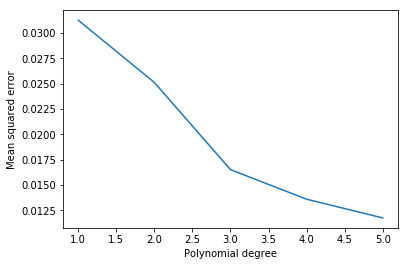

In [85]:
plt.figure()
plt.plot(MPD,MSE_degree)
plt.xlabel('Polynomial degree')
plt.ylabel('Mean squared error')
plt.show()

It seems the model complexity isnt high enough for the curve to have a minimum like Hastie 2.11. To increase model complexity, a different inversion method is required, due to round-off-error, or what its called.

# d

In [86]:
_lambda = np.logspace(-4,5,10)

RidgeMSE = np.zeros((len(MPD),len(_lambda)))
RidgeR2 = np.zeros((len(MPD),len(_lambda)))

for i,mpd in enumerate(MPD):
    X = Model(x,y,mpd)
    for j,lam in enumerate(_lambda):
#         rMSE,rR2 = NoResampling(X,z_n,lam)
        rMSE,rR2 = kFoldRidge(k,X,z_n,lam)
        RidgeMSE[i][j] = rMSE
        RidgeR2[i][j] = rR2

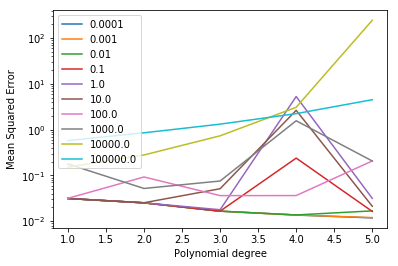

In [87]:
plt.figure()

for i in range(len(_lambda)):
    plt.semilogy(MPD,RidgeMSE[:,i],label=_lambda[i])
plt.xlabel('Polynomial degree')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

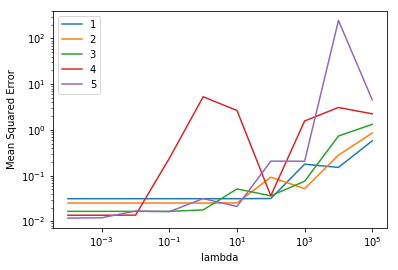

In [88]:
plt.figure()

for i in range(len(MPD)):
    plt.loglog(_lambda,RidgeMSE[i,:],label=i+1)
plt.xlabel('lambda')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# e

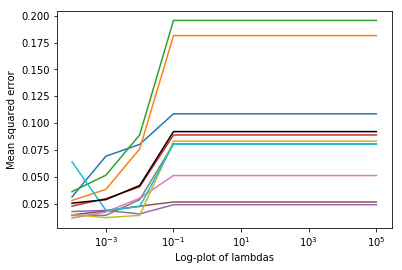

(0.017228051448769353, 0.7280001488269142)

In [89]:
# I'll use Scikit-learn as recommended for this
kFoldLassoCV(k,X,z_n,_lambda)


In [ ]:
#morten spm:
# confidence interval
# bias variance: 
#use each fold to make mean, or run 10 shuffled k-folds?
#lambdas are usually horrible